# 02806 Social data analysis and visualization Spring 23

# Final Project Assignment B

# Part 1: Motivation

### 1.1: What is your dataset?

There is XXX different datasets in this project. The first is the vehichle crash reports from NYC from the years 2013-2023. The second dataset is the daily weather in that period. Furthermore, a geojson dataset describing different regions in manhatten is used, primarily for visualization purposes.

The vehichle crash dataset consists of many columns where the most relavant onces are the following:

* The date of the crash
* The time of the crash
* The location of the crash given in a lat/lon pair
* The number of people injured/killed in the crash
* The contributing factor for the vehichles involved
* The type of vehicles involved




The weather data consists of five columns:

* A date column of the format year-month-day
* A temperature column with the mean temperature of the day in celsius
* A rain column with the sum of rainfall in mm
* A snow column with the sum of snowfall in cm
* Two wind columns with the max windspeed and the max windgusts, both displayed in km/h


### 1.2: Why did you choose these particular datasets?

### 1.3: What was your goal for the end user's experience?

In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import osmnx as ox
plt.style.use('ggplot')

c:\Users\Frede\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Frede\AppData\Local\Temp\ipykernel_11520\2672279996.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [30]:
'''
The code below was the initial read of the data.
As the code takes quite some time to run (as it gets rid of all crashes not in manhatten) 
It was easier to save the file to a pickle afterwards and just work with that pickle file

import osmnx as ox
import geopandas as gpd

df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', on_bad_lines='skip', sep=';')
df = df.dropna(subset=['LATITUDE'])
city = ox.geocode_to_gdf('Manhattan, New York City, New York, USA')
manhattan_polygon = city.geometry.iloc[0]
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE), crs='EPSG:4326')
gdf = gdf[gdf.geometry.within(manhattan_polygon)]

'''

df = pd.read_pickle('gdf_pickle.pkl')

#removing all chrashes that is not geotagged
df = df.dropna(subset=['LATITUDE'])
df['BOROUGH'] = 'MANHATTAN'
df['date'] = pd.to_datetime(df['CRASH DATE'])
df['time'] = pd.to_datetime(df['CRASH TIME'])
df.columns = df.columns.str.lower()
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].apply(lambda x: x.strftime('%A'))
#only taking the data from 2013-2022 as 2023 is incomplete. 
mask = (df['date'] > '12/31/2012') & (df['date'] <= '12/31/2022')
df = df.loc[mask]
# adding an id so that plotly gets a location for each crash
df['id'] = range(len(df))

#reading in the weather data
df_weather = pd.read_excel('open-meteo-40.70N74.00W27m.xlsx')
df_weather['date'] = df_weather['time']
del df_weather['time']

#Merging the dataframes so each crash has the weatherdata for that day. 
df = pd.merge(df, df_weather, on='date', how='left')

crashes_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))



C:\Users\Frede\AppData\Local\Temp\ipykernel_11520\3716724925.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['CRASH TIME'])


In [4]:
df_streets = pd.read_csv('Centerline.csv', on_bad_lines='skip',sep=';')

C:\Users\Frede\AppData\Local\Temp\ipykernel_11520\3829383476.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_streets = pd.read_csv('Centerline.csv', on_bad_lines='skip',sep=';')


In [3]:
road_df = gpd.read_file('road.geojson')

In [6]:
place_name = "Manhattan, New York City, New York, USA"

# Download the street network graph for Manhattan
G = ox.graph_from_place(place_name, network_type="drive")

# Print some basic stats about the graph
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 4570
Number of edges: 9843


In [7]:
road_lengths = {}

# Iterate over all edges in the graph and accumulate lengths by road name
for u, v, k, data in G.edges(keys=True, data=True):
    length = data['length']
    name = tuple(data['name']) if 'name' in data else ('<unnamed>',)
    if name in road_lengths:
        road_lengths[name] += length
    else:
        road_lengths[name] = length

# Convert the dictionary to a DataFrame
df_roads = pd.DataFrame.from_dict(road_lengths, orient='index', columns=['total_length'])
df_roads = df_roads.reset_index()
df_roads['road_name'] = df_roads['index'].apply(lambda x: ''.join(x).upper())
df_roads.drop('index',inplace=True, axis=1)

In [8]:
df_roads

total_length                    road_name
0        7943.728            CENTRAL PARK WEST
1        1928.448            WEST 106TH STREET
2        3733.348             MANHATTAN AVENUE
3        4134.692              COLUMBUS AVENUE
4       17032.555             AMSTERDAM AVENUE
..            ...                          ...
821        73.897              CONGRESS STREET
822       334.610  11TH AVENUEWEST 24TH STREET
823        91.491                  HOGAN PLACE
824       245.751         WILLIS AVENUE BRIDGE
825       309.773       CHERRY STREETFDR DRIVE

[826 rows x 2 columns]

In [31]:
road_lengths = dict(zip(df_roads['road_name'], df_roads['total_length']))

# Map the road lengths to the 'road' column of the df DataFrame
df['road_length'] = df['on street name'].map(road_lengths)

In [84]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

dftemp = df.loc[df['year']==2017] 
dftemp = dftemp.dropna(subset=['on street name'])

# Count the occurrences of each street name
counts = dftemp['on street name'].value_counts()
dftemp['count'] = dftemp['on street name'].map(counts)

# Normalize the counts so that the highest count is equal to 1
dftemp['normalized_count'] = dftemp['count'] / dftemp['count'].max()

# Define a color scale that ranges from light to dark red
color_scale = [
    [0, 'rgb(255, 245, 240)'],
    [0.2, 'rgb(254, 224, 210)'],
    [0.4, 'rgb(252, 187, 161)'],
    [0.6, 'rgb(252, 146, 114)'],
    [0.8, 'rgb(251, 106, 74)'],
    [1, 'rgb(203, 24, 29)']
]

# Create the Plotly scattermapbox plot
fig = px.scatter_mapbox(dftemp, lat='latitude', lon='longitude', text='on street name',
                        color='normalized_count')

fig.update_layout(mapbox_style='carto-positron', mapbox_zoom=11,
                  mapbox_center={'lat': dftemp['latitude'].mean(), 'lon': dftemp['longitude'].mean()})
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)
fig.show()


In [59]:
df_boroughs = gpd.read_file('2010 Neighborhood Tabulation Areas (NTAs).geojson')
areas = df_boroughs.loc[df_boroughs['boro_name']=='Manhattan']

# spatial join the crashes GeoDataFrame with the areas GeoDataFrame
crashes_areas = gpd.sjoin(crashes_gdf, df_boroughs, how='left', op='within')

#Adding the area name for each crash to the dataframe
df['ntaname'] = crashes_areas['ntaname']

c:\Users\Frede\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [32]:
#A function to determine a rough weather category
def weather_category(row):
    if row['snowfall_sum (cm)'] > 0:
        return 'Snow'
    elif row['rain_sum (mm)'] > 0:
        return 'Rain'
    elif row['windgusts_10m_max (km/h)'] > 50:
        return 'Windy'
    else:
        return 'Other'

# Applying the category function to each row of the dataframe
df['weather_category'] = df.apply(weather_category, axis=1)

In [38]:
df_mac = df.drop(columns=['crash date','crash time','borough','zip code', 'location', 'id', 'date', 'geometry', 'on street name', 'cross street name',
       'off street name',])

In [39]:
weekday_map = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df_mac['weekday'] = df_mac['weekday'].map(weekday_map)

month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

df_mac['month'] = df_mac['month'].map(month_map)
df_mac

latitude  longitude  number of persons injured   
0       40.751440 -73.973970                        0.0  \
1       40.748917 -73.993546                        0.0   
2       40.804375 -73.937420                        1.0   
3       40.784615 -73.953964                        1.0   
4       40.790276 -73.939600                        1.0   
...           ...        ...                        ...   
352085  40.720320 -73.994050                        0.0   
352086  40.828297 -73.950870                        0.0   
352087  40.862923 -73.927770                        0.0   
352088  40.863690 -73.917070                        0.0   
352089  40.736020 -73.982280                        0.0   

        number of persons killed  number of pedestrians injured   
0                            0.0                              0  \
1                            0.0                              0   
2                            0.0                              1   
3                            0.0                              0   
4                            0.0                              1   
...                          ...                            ...   
352085                       0.0                              0   
352086                       1.0                              0   
352087                       0.0                              0   
352088                       0.0                              0   
352089                       0.0                              0   

        number of pedestrians killed  number of cyclist injured   
0                                  0                          0  \
1                                  0                          0   
2                                  0                          0   
3                                  0                          1   
4                                  0                          0   
...                              ...                        ...   
352085                             0                          0   
352086                             1                          0   
352087                             0                          0   
352088                             0                          0   
352089                             0                          0   

        number of cyclist killed  number of motorist injured   
0                              0                           0  \
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   
...                          ...                         ...   
352085                         0                           0   
352086                         0                           0   
352087                         0                           0   
352088                         0                           0   
352089                         0                           0   

        number of motorist killed  ... month  year weekday   
0                               0  ...    12  2021       2  \
1                               0  ...    12  2021       6   
2                               0  ...    12  2021       2   
3                               0  ...    12  2021       2   
4                               0  ...     4  2022       5   
...                           ...  ...   ...   ...     ...   
352085                          0  ...     2  2022       4   
352086                          0  ...     9  2022       7   
352087                          0  ...    12  2022       3   
352088                          0  ...     3  2022       2   
352089                          0  ...     3  2022       7   

       temperature_2m_mean (°C) rain_sum (mm)  snowfall_sum (cm)   
0                      5.212500      0.000000               0.00  \
1                     11.712501      7.9

In [40]:
df_mac = df_mac.drop(columns=['collision_id', 'vehicle type code 1', 'vehicle type code 2',
       'vehicle type code 3', 'vehicle type code 4', 'vehicle type code 5',
       'time'])

In [56]:
df_mac = pd.get_dummies(df_mac)
df_mac['number of persons injured or killed']=df_mac['number of persons injured']+df_mac['number of persons killed']
df_mac = df_mac.fillna(0)

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



X = df_mac
X.drop(['number of persons injured or killed', 'number of persons injured', 'number of persons killed'], axis=1)
y = df_mac['number of persons injured or killed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a Random Forest Regression model with 100 trees
rf = RandomForestRegressor(n_estimators=100)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.4605072566673205e-06


## 2: Basic stats. Let's understand the dataset better

### 2.1: Write about your choices in data cleaning and preprocessing

To prepare the data for analysis a standard number of steps were taken, such as changing the time and date column to date types and adding the year, month and weekday to each row. Further an id was added to each crash to make it easier to work with plotly. The data is limited to be between 2013-2022 as 2023 is of course in complete. Also the original dataset contained crash data for the entire new york city and this analysis will be limited to the Manhatten borough. The data was sorted using the ox library to extract the geographical area of Manhatten and then only keep the rows that is within Manhatten. To make the file available on github the preprocessing was done in two steps, as the csv file with the crashes is too big. Thus that data is available at https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

The weather data was proccesed such that each day gets a weather category. This means that if the amount of rain is above 0 mm the day gets classified as rainy, the same is the case for snow and if the windgust was above 50 km/h (which is roughly 14 m/s) the day was classified as windy. 




### 2.2: Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.



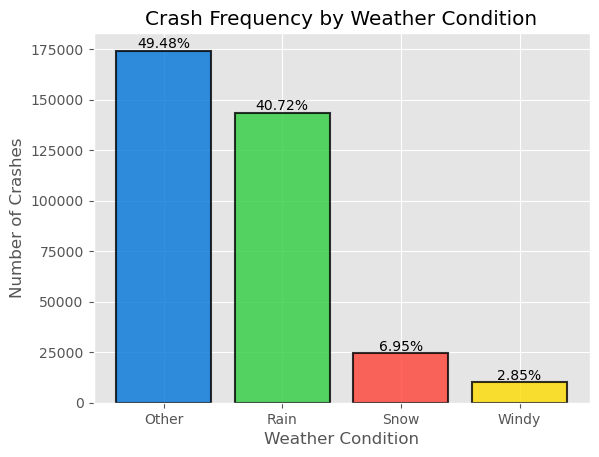

In [5]:
crash_counts = df.groupby('weather_category')['id'].count()

# Calculate the percentage of days in the dataset where each weather condition is present
percentages = (crash_counts / len(df)) * 100

# Create the bar chart with percentages as text annotations
plt.bar(crash_counts.index, crash_counts.values, 
        tick_label=crash_counts.index,
        color=['#0074D9', '#2ECC40', '#FF4136', '#FFDC00'],
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8,
        align='center',
        )
plt.xlabel('Weather Condition')
plt.ylabel('Number of Crashes')
plt.title('Crash Frequency by Weather Condition')

# Add percentages as text annotations on the bars
for i, v in enumerate(crash_counts.values):
    plt.text(i, v, f"{percentages[i]:.2f}%", 
             color='black', 
             fontsize=10, 
             ha='center', 
             va='bottom')

plt.show()

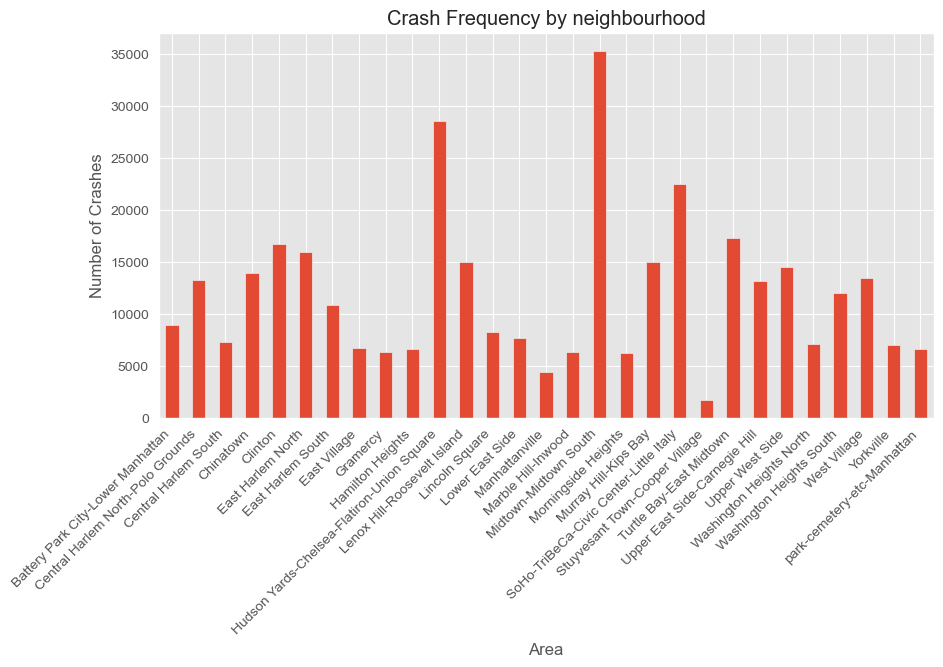

In [104]:
crash_counts = df.groupby('area_name')['id'].count()

# Create a bar chart of the crash counts by weather condition
plt.figure(figsize=(10, 5))
ax = crash_counts.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Area')
plt.ylabel('Number of Crashes')
plt.title('Crash Frequency by neighbourhood')
plt.show()

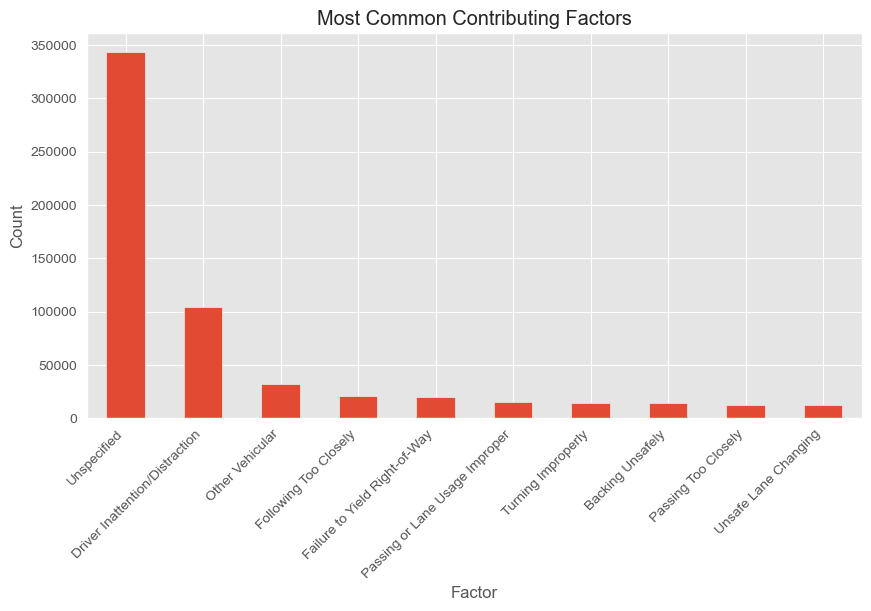

In [72]:
factors = df[['contributing factor vehicle 1', 'contributing factor vehicle 2',
              'contributing factor vehicle 3', 'contributing factor vehicle 4',
              'contributing factor vehicle 5']].stack().value_counts()

# Create a bar chart of the counts
plt.figure(figsize=(10, 5))
ax = factors[0:10].plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Most Common Contributing Factors')
plt.xlabel('Factor')
plt.ylabel('Count')
plt.show()

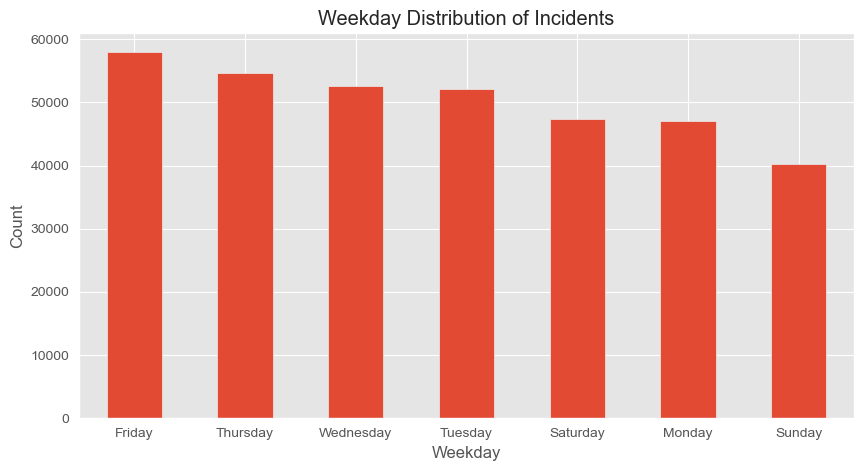

In [78]:
weekday_count = df['weekday'].value_counts()

# Create bar plot of weekday distribution
plt.figure(figsize=(10, 5))
ax = weekday_count.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_title('Weekday Distribution of Incidents')
ax.set_xlabel('Weekday')
ax.set_ylabel('Count')
plt.show()

In [59]:
df.to_csv('data.csv')

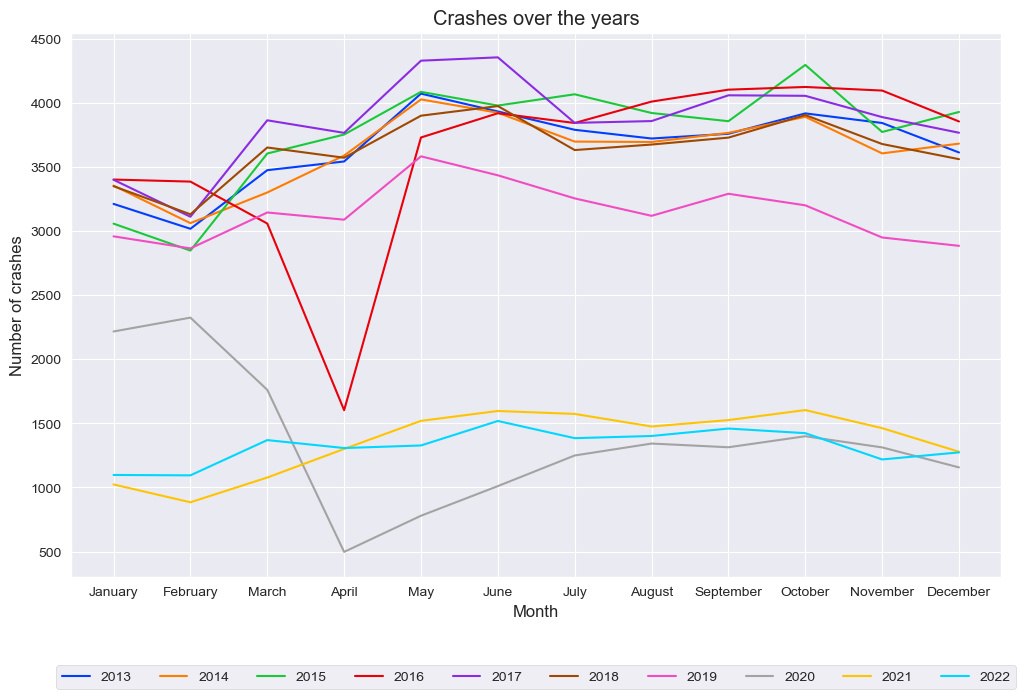

In [39]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df = df.sort_values('month')
monthly_data = df.groupby(['year', 'month']).size().reset_index(name='Crashes')

# Pivot the data to create a matrix with years as rows and months as columns
pivot_data = monthly_data.pivot(index='month', columns='year', values='Crashes')

colors = sns.color_palette('bright', n_colors=len(pivot_data.columns))

# Apply the "darkgrid" style from seaborn
sns.set_style('darkgrid')

# Create the plot
plt.figure(figsize=(12,8))
for i, year in enumerate(pivot_data.columns):
    plt.plot(pivot_data[year], color=colors[i], label=str(year))
plt.legend(loc='upper center', fontsize='medium', bbox_to_anchor=(0.5, -0.15), ncol=10)
plt.xlabel('Month')
plt.ylabel('Number of crashes')
plt.title('Crashes over the years')
# Adjust the plot margins to make room for the legend
plt.subplots_adjust(bottom=0.2)
# Save the plot as a PNG file
plt.savefig('Timeseries_of_crashes', dpi=300)
plt.show()

In [5]:
weekday_dict = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
month_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Apply the mapping to the weekday column
df['weekday_num'] = df['weekday'].map(weekday_dict)
df['month_num'] = df['month'].map(month_dict)

corr=['zip code', 'latitude','longitude','number of persons killed', 'number of pedestrians injured',
       'number of pedestrians killed', 'number of cyclist injured',
       'number of cyclist killed', 'number of motorist injured',
       'number of motorist killed','weekday_num','month_num' , 'year','temperature_2m_mean (°C)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)',]

In [8]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo
# Convert the 'Date' column to a datetime object

# Filter the data to only include days in 2017
df_2017 = df.loc[df['year'] == 2017]

# Define the layout
layout = go.Layout(
    title='Crashes in 2017',
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiZm9tbXVuZHNlbiIsImEiOiJjbGZpZGQ2YnQyYmp2M3FuMXZnd3c2dHh3In0.ptE5IqV4qgCHGKSzZQ02Yw',
        bearing=0,
        center=dict(
            lat=40.72,
            lon=-74.0
        ),
        pitch=0,
        zoom=9
    ),
    updatemenus=[dict(
        buttons=[
            dict(
                args=[{'z': [df.pivot_table(index='latitude', columns='longitude', values='id')]}],
                label='All Crashes',
                method='restyle'
            ),
            dict(
                args=[{'z': [df_2017.pivot_table(index='latitude', columns='longitude', values='rain_sum (mm)')]}],
                label='Rainy Days in 2017',
                method='restyle'
            )
        ],
        direction='down',
        showactive=True,
        x=0.1,
        xanchor='left',
        y=1.1,
        yanchor='top'
    )]
)

# Create the heatmap
data = [go.Densitymapbox(
    lat=df['latitude'],
    lon=df['longitude'],
    z=df.pivot_table(index='latitude', columns='longitude', values='id'),
    hovertemplate='%{z} crashes<br>latitude: %{lat:.2f}<br>longitude: %{lon:.2f}<extra></extra>',
    colorscale='YlOrRd'
)]

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
pyo.plot(fig, filename='crash_map.html')


In [22]:
rainy_days = df.loc[(df['number of persons killed'] > 0) & (df['rain_sum (mm)'] > 0)]

no_rain_days = df.loc[(df['number of persons killed'] > 0) & (df['rain_sum (mm)'] == 0)]

# Create the first density map using the latitude and longitude columns
fig = px.density_mapbox(rainy_days, lat='latitude', lon='longitude', radius=10,
                        mapbox_style="carto-positron", 
                        zoom=11, 
                        center={"lat": 40.7628, "lon": -73.9560},
                        hover_data=['date', 'number of persons killed'],
                        title=('Location of crashes leading to fatalities with rain'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800)

# Add the second layer with rain_sum (mm) == 0
fig.add_scattermapbox(
    lat=no_rain_days['latitude'],
    lon=no_rain_days['longitude'],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        opacity=0.6,
    ),
    name='No Rain'
)

fig.show()


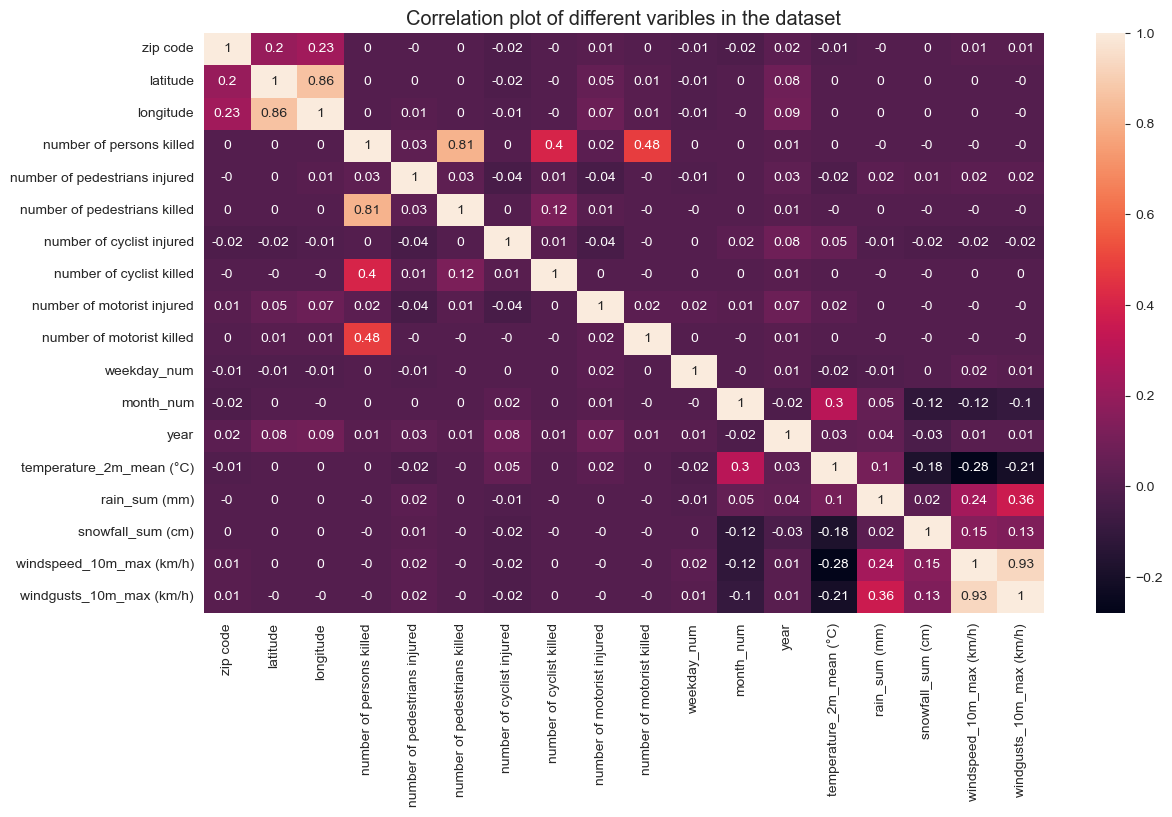

In [54]:
df_selected = df[corr]
plt.figure(figsize=(15,10))
sns.heatmap(df_selected.corr().round(2),annot=True)
plt.title('Correlation plot of different varibles in the dataset')
plt.subplots_adjust(bottom=0.3, left=0.2)
# Save the plot as a PNG file
plt.savefig('Correlation_plot.png', dpi=300)

In [122]:
crash_counts = df.groupby("ntaname").size().reset_index(name="crash_count")

# Merge the crash counts with the area geometry data
merged_gdf = df_boroughs.merge(crash_counts, on="ntaname")
merged_gdf['id']=range(len(merged_gdf))
# Create a choropleth plot showing the distribution of crashes across areas
fig = px.choropleth_mapbox(merged_gdf, geojson=merged_gdf.geometry, color="crash_count",
                           locations="id",
                           mapbox_style="carto-positron", 
                           zoom=11, 
                           center={"lat": 40.7128, "lon": -74.0060},
                           opacity=0.5, color_continuous_scale="Viridis",
                           labels={"crash_count": "Crash Count"},
                           title="Number of crashes across neighbourhoods in NYC")
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000)
fig.show()

In [9]:
import numpy as np
import plotly.offline as pyo

dftemp = df.loc[df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Alcohol Involvement']

def animate_map(time_col):
    fig = px.scatter_mapbox(dftemp,
              lat="latitude" ,
              lon="longitude",
              hover_name="BOROUGH",
              color="CONTRIBUTING FACTOR VEHICLE 1",
              animation_frame=time_col,
              mapbox_style='carto-positron',
              category_orders={
              time_col:list(np.sort(dftemp[time_col].unique()))
              },                  
              zoom=10)
    fig.update_layout(
    autosize=False,
    width=1500,
    height=1000)
    fig.show()

    pyo.plot(fig, filename='html_files/vehicle_crashes_map.html', auto_play=False)
animate_map(time_col='year')